## <p style="text-align: center;">MIS 285N - Big Data and Distributed Programming</p>
## <p style="text-align: center;">Problem Set 4: Machine Learning Experiments</p>
## <p style="text-align: center;">Total points: 50</p>
## <p style="text-align: center;">Due: Tuesday, 15th October submitted via Canvas by 11:59 pm</p>

Your homework should be written in a **Jupyter notebook**.

Also, please make sure your code runs and the graphics (and anything else) are displayed in your notebook before submitting.

In this Problem Set we will develop a Recommender system, in part 2, predict the MNIST label with the confidence score. 


# Task 1
Using the data provided on movie ratings, create a movie recommender system based on User-based CF and Item-based CF. 
Load the movie recommender dataset provided in the zip-file. We've worked with this dataset in class. 

1.   In this part, you need to implement an user-based CF method and recommend movies for a given user. Recommend top-5 movies for userId 10. 
2.   In this part, you need to implement an item-based CF method and recommend movies for a given user. Recommend top-5 movies for userId 10.

Are they different? If yes, which of the above two method worked better and why?
Please refer to the class notes on details on the user-based and item-based recommender systems. 

In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
import itertools

In [2]:
movies = pd.read_csv(r'ml-latest-small/movies.csv')
ratings = pd.read_csv(r'ml-latest-small/ratings.csv')
user_tag = pd.read_csv(r'ml-latest-small/tags.csv')
links = pd.read_csv(r'ml-latest-small/links.csv')

In [3]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
movies.shape

(9742, 3)

In [5]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
user_tag.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [7]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [8]:
ratings_new = pd.merge(ratings, movies, on='movieId')

In [9]:
ratings_new.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


## User-Based CF

### Step 1 - Mean Normalization of movie ratings by user

In [10]:
Mean = ratings_new.groupby(by="userId",as_index=False)['rating'].mean()
Mean.head()

,userId,rating
0,1,4.366379
1,2,3.948276
2,3,2.435897
3,4,3.555556
4,5,3.636364


In [11]:
Rating_avg = pd.merge(ratings_new,Mean,on='userId')
Rating_avg['Normal_Rating']=Rating_avg['rating_x']-Rating_avg['rating_y']
Rating_avg.head()

,userId,movieId,rating_x,timestamp,title,genres,rating_y,Normal_Rating
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.366379,-0.366379
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance,4.366379,-0.366379
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller,4.366379,-0.366379
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,4.366379,0.633621
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,4.366379,0.633621


In [12]:
user_movie_temp = Rating_avg.pivot_table(index='userId', columns='movieId', values='Normal_Rating')
user_movie_temp.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,-0.366379,NaN,-0.366379,NaN,NaN,-0.366379,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.363636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
user_movie = user_movie_temp.fillna(0)
user_movie.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,-0.366379,0.0,-0.366379,0.0,0.0,-0.366379,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.363636,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
user_movie.shape

(610, 9724)

### Step 2 - Calculate users cosine similarity 

In [15]:
cosine = cosine_similarity(user_movie)
np.fill_diagonal(cosine, 0 )
user_cosine =pd.DataFrame(cosine,index=user_movie.index)
user_cosine.columns=user_movie.index
user_cosine.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.001265,0.000553,0.048419,0.021847,-0.045497,-0.006200,0.047013,0.019510,-0.008754,...,0.018127,-0.017172,-0.015221,-0.037059,-0.029121,0.012016,0.055261,0.075224,-0.025713,0.010932
2,0.001265,0.000000,0.000000,-0.017164,0.021796,-0.021051,-0.011114,-0.048085,0.000000,0.003012,...,-0.050551,-0.031581,-0.001688,0.000000,0.000000,0.006226,-0.020504,-0.006001,-0.060091,0.024999
3,0.000553,0.000000,0.000000,-0.011260,-0.031539,0.004800,0.000000,-0.032471,0.000000,0.000000,...,-0.004904,-0.016117,0.017749,0.000000,-0.001431,-0.037289,-0.007789,-0.013001,0.000000,0.019550
4,0.048419,-0.017164,-0.011260,0.000000,-0.029620,0.013956,0.058091,0.002065,-0.005874,0.051590,...,-0.037687,0.063122,0.027640,-0.013782,0.040037,0.020590,0.014628,-0.037569,-0.017884,-0.000995
5,0.021847,0.021796,-0.031539,-0.029620,0.000000,0.009111,0.010117,-0.012284,0.000000,-0.033165,...,0.015964,0.012427,0.027076,0.012461,-0.036272,0.026319,0.031896,-0.001751,0.093829,-0.000278


### Step 3 - Find n most similar users for each userId in descending order of cosine similarity

In [16]:
def most_similar_users(df,n):
    # order = np.argsort(df.values, axis=1)[:, :n]
    df = df.apply(lambda x: pd.Series(x.sort_values(ascending=False)
           .iloc[:n].index, 
            index=['Sim_User {}'.format(i) for i in range(1, n+1)]), axis=1)
    return df

In [17]:
most_similar_users_60 = most_similar_users(user_cosine,60)
most_similar_users_60.head()

,Sim_User 1,Sim_User 2,Sim_User 3,Sim_User 4,Sim_User 5,Sim_User 6,Sim_User 7,Sim_User 8,Sim_User 9,Sim_User 10,...,Sim_User 51,Sim_User 52,Sim_User 53,Sim_User 54,Sim_User 55,Sim_User 56,Sim_User 57,Sim_User 58,Sim_User 59,Sim_User 60
userId,,,,,,,,,,,,,,,,,,,,,
1,301,597,414,477,57,369,206,535,590,418,...,178,399,288,115,76,302,328,448,344,385
2,189,246,378,209,227,326,393,332,196,528,...,43,213,25,523,468,125,298,184,357,91
3,441,496,549,231,527,537,313,518,244,246,...,73,158,95,28,445,561,66,362,533,335
4,75,137,590,391,43,128,462,250,290,85,...,192,605,305,219,308,330,206,297,521,364
5,145,35,565,134,58,444,446,347,530,142,...,203,46,229,301,403,96,107,328,118,338


### Step 4 - Find top 5 most popular movies watched by most similar users 

In [165]:
def user_based_suggestions(user):
    
    user_movie_list= user_movie_temp.columns[user_movie_temp[user_movie_temp.index==user].notna().any()].tolist()
    sim_user = most_similar_users_60[most_similar_users_60.index==user].values
    sim_user_list = sim_user.squeeze().tolist()
    sim_user_movies = user_movie[user_movie.index.isin(sim_user_list)]
    sim_user_movies_list = ','.join(map(str,sim_user_movies.columns))
    sim_user_movies_list = sim_user_movies_list.split(',')
    
    semi_final_movie_list = set(map(int,sim_user_movies_list))-set(user_movie_list)
    semi_final_movie_list = list(semi_final_movie_list)
    
    final_movie_list = defaultdict(float)
    for movie in semi_final_movie_list:
        movie_user = sim_user_movies.loc[:,movie]
        for sim_user, rating in movie_user.iteritems():
            # Weighted ranking computation based on user cosine
            final_movie_list[movie]+=rating*user_cosine[user][sim_user] 
    
    final_movie_df = pd.Series(final_movie_list).to_frame('new_col').reset_index()
    final_movie_df.columns = ['movieId', 'Total_Rating']
    top_5_movie_id = final_movie_df.sort_values(by='Total_Rating',ascending=False).head(5)
    top_5_movie_name = top_5_movie_id.merge(movies, how='inner', on='movieId')
    top_5_movie_name_list = top_5_movie_name.title.values.tolist()
#     print(len(final_movie_list))
    return top_5_movie_name_list

In [166]:
recommended_movie_list = user_based_suggestions(10)
print("Movie Recommendations for User Id 10 are: ")
print("   ")
for movie in recommended_movie_list:
    print(movie)

Movie Recommendations for User Id 10 are: 
   
Shawshank Redemption, The (1994)
Star Wars: Episode IV - A New Hope (1977)
Schindler's List (1993)
Apollo 13 (1995)
Bourne Identity, The (2002)


## Item-Based CF

### Step 1 - Build movie-user matrix for ratings

In [28]:
movie_user_temp = Rating_avg.pivot_table(index='movieId', columns='userId', values='Normal_Rating')
movie_user_temp.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,-0.366379,NaN,NaN,NaN,0.363636,NaN,1.269737,NaN,NaN,NaN,...,-0.425743,NaN,0.492047,-0.48,0.789593,-1.157399,0.213904,-0.634176,-0.27027,1.311444
2,NaN,NaN,NaN,NaN,NaN,0.506369,NaN,0.425532,NaN,NaN,...,NaN,0.607407,NaN,1.52,0.289593,NaN,NaN,-1.134176,NaN,NaN
3,-0.366379,NaN,NaN,NaN,NaN,1.506369,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.134176,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,-0.493631,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,1.506369,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.48,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
movie_user = movie_user_temp.fillna(0)
movie_user.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,-0.366379,0.0,0.0,0.0,0.363636,0.000000,1.269737,0.000000,0.0,0.0,...,-0.425743,0.000000,0.492047,-0.48,0.789593,-1.157399,0.213904,-0.634176,-0.27027,1.311444
2,0.000000,0.0,0.0,0.0,0.000000,0.506369,0.000000,0.425532,0.0,0.0,...,0.000000,0.607407,0.000000,1.52,0.289593,0.000000,0.000000,-1.134176,0.00000,0.000000
3,-0.366379,0.0,0.0,0.0,0.000000,1.506369,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,-1.134176,0.00000,0.000000
4,0.000000,0.0,0.0,0.0,0.000000,-0.493631,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
5,0.000000,0.0,0.0,0.0,0.000000,1.506369,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,-0.48,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000


### Step 2 - Calculate movie cosine similarity 

In [30]:
cosine = cosine_similarity(movie_user)
np.fill_diagonal(cosine, 0 )
movie_cosine =pd.DataFrame(cosine,index=movie_user.index)
movie_cosine.columns=movie_user.index
movie_cosine.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.061511,0.051260,-0.036175,-0.140422,0.089142,-0.039411,0.003109,-0.105122,-0.053247,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.061511,0.000000,0.056252,-0.106873,0.081893,-0.031387,0.020577,0.053926,-0.009668,-0.131687,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.051260,0.056252,0.000000,-0.035193,0.100357,-0.008854,0.060727,-0.057899,-0.011744,-0.107283,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.036175,-0.106873,-0.035193,0.000000,0.021928,-0.017004,0.007410,0.024516,0.000000,0.118102,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,-0.140422,0.081893,0.100357,0.021928,0.000000,-0.052783,0.146651,0.002130,0.097845,0.026574,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Step 3 - Find n most similar movies for each movieId in descending order of cosine similarity

In [31]:
def most_similar_movies(df,n):
    order = np.argsort(df.values, axis=1)[:, :n]
    df = df.apply(lambda x: pd.Series(x.sort_values(ascending=False)
           .iloc[:n].index, 
            index=['Sim_Movie {}'.format(i) for i in range(1, n+1)]), axis=1)
    return df

In [32]:
most_similar_movies_1000 = most_similar_movies(movie_cosine,1000)
most_similar_movies_1000.head()

,Sim_Movie 1,Sim_Movie 2,Sim_Movie 3,Sim_Movie 4,Sim_Movie 5,Sim_Movie 6,Sim_Movie 7,Sim_Movie 8,Sim_Movie 9,Sim_Movie 10,...,Sim_Movie 991,Sim_Movie 992,Sim_Movie 993,Sim_Movie 994,Sim_Movie 995,Sim_Movie 996,Sim_Movie 997,Sim_Movie 998,Sim_Movie 999,Sim_Movie 1000
movieId,,,,,,,,,,,,,,,,,,,,,
1,3114,78499,588,1148,1270,8961,3671,6377,2716,1198,...,791,1144,63222,104419,1693,61132,76093,48774,122900,4225
2,1107,2091,109895,6959,62511,57951,91622,71248,134528,134783,...,339,60040,31435,94953,5152,76173,2671,2496,8950,1388
3,3450,1461,2133,387,2170,3698,2418,1006,1867,1677,...,34072,2018,340,106873,4994,2436,52319,4312,4623,588
4,2800,46664,7395,3964,1551,6978,4814,72,7255,26614,...,4298,4359,4367,4368,4369,4371,4372,4373,4374,4378
5,78544,4221,60128,4929,2103,49957,45635,4138,6039,5437,...,5427,5387,2915,4535,4971,3798,406,287,726,987


In [33]:
def unique(list1): 
    x = np.array(list1) 
    return(np.unique(x)) 

### Step 4 - Find top 5 most movies similar to movies rated > 0 by given user 

In [169]:
def movie_based_suggestions(user):
    
    sim_movies = []
    user_movie_list= user_movie_temp.columns[user_movie_temp[user_movie_temp.index==user].notna().any()].tolist()
    user_movie_list_ranked= user_movie[user_movie.index==user]
    user_movie_list_ranked = user_movie_list_ranked.columns[user_movie_list_ranked[user_movie_list_ranked.values>0].any()]
    for movie in user_movie_list_ranked:
        sim_movies.append((most_similar_movies_1000[most_similar_movies_1000.index==movie].values.flatten()).tolist())
    
    sim_movie_list = list(itertools.chain.from_iterable(sim_movies))
    sim_movie_list2 = unique(sim_movie_list)
    
    semi_final_movie_list = set(sim_movie_list2)-set(user_movie_list)
    semi_final_movie_list = list(semi_final_movie_list)
    
    final_movie_list_rating = defaultdict(float)
    final_movie_list_cosine = pd.DataFrame(pd.np.empty((0, 140)))
    final_movie_list_cosine.columns = list(user_movie_list_ranked)
    final_movie_list_cosine['movie']=list(semi_final_movie_list)
    final_movie_list_cosine=final_movie_list_cosine.set_index('movie')
    
    for movie1 in semi_final_movie_list:
        for movie2 in user_movie_list_ranked:
            final_movie_list_cosine.at[movie1,movie2]=movie_cosine[movie1][movie2]
    
    final_movie_list_cosine_sum = final_movie_list_cosine.sum(axis=1)
        
    for movie in semi_final_movie_list:
        sim_movies_ratings_total = movie_user.loc[movie,:]
        for rating in sim_movies_ratings_total:
            final_movie_list_rating[movie]+=rating
        # Weighted movie ranking computation based on movie cosine similarity with given user's movies
        final_movie_list_rating[movie]=final_movie_list_rating[movie]*final_movie_list_cosine_sum.loc[movie]
        
    final_movie_df = pd.Series(final_movie_list_rating).to_frame('new_col').reset_index()
    final_movie_df.columns = ['movieId', 'Total_Rating']
    top_5_movie_id = final_movie_df.sort_values(by='Total_Rating',ascending=False).head(5)
    top_5_movie_name = top_5_movie_id.merge(movies, how='inner', on='movieId')
    top_5_movie_name_list = top_5_movie_name.title.values.tolist()
    return top_5_movie_name_list
   # print(final_movie_list_rating)


In [170]:
recommended_movie_list = movie_based_suggestions(10)
print("Movie Recommendations for User Id 10 are: ")
print("   ")
for movie in recommended_movie_list:
    print(movie)

Movie Recommendations for User Id 10 are: 
   
Shawshank Redemption, The (1994)
Silence of the Lambs, The (1991)
Star Wars: Episode V - The Empire Strikes Back (1980)
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
Star Wars: Episode IV - A New Hope (1977)


## Analysis

### <font color=orange> Top 5 movie recommendations for User Id 10 obtained via User-based and item-based CF are different. User-based CF is most likely not effective in this example because on one hand the total number of movies are very large and on the other hand, actual number of movies which users have rated is very small. The resulting user-movie matrix is extremely sparse and user-based CF algorithm ends up using these limited ratings to compute similarity between any user pair. Not suprisingly, the accuracy of the prediction by UBCF would be very low as compared to Item-based CF.</font>

# Task 2
Refer to the classification-clothing.ipynb. In this notebook, we worked with FashionMNIST dataset and developed a model. The predictions were made with a confidence score. In this task, you would have to implement the same model on MNSIT dataset. Finally, generate a graph of predictions along with their confidence score as shown below. 

Include the code and the graph in your submissions. The reference graph is given below. 

## Import MNIST dataset

In [174]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.0.0


In [175]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

Using TensorFlow backend.


In [176]:
print('Rows: %d, columns: %d' % (x_train.shape[0], x_train.shape[1]))
print('Rows: %d, columns: %d' % (x_test.shape[0], x_test.shape[1]))

Rows: 60000, columns: 28
Rows: 10000, columns: 28


In [177]:
print(x_train.shape,y_train.shape, x_test.shape, y_test.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


## Explore the data

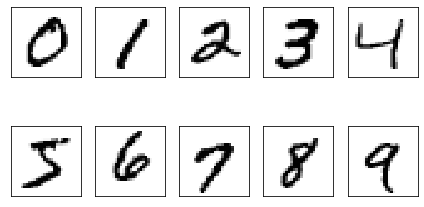

In [179]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(10):
    img = x_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('./figures/mnist_all.png', dpi=300)
plt.show()

## Preprocess the data

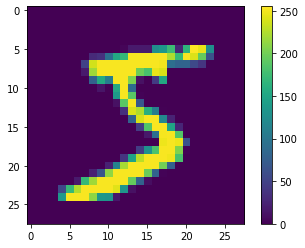

In [180]:
plt.figure()
plt.imshow(x_train[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [181]:
x_train = x_train / 255.0

x_test = x_test / 255.0

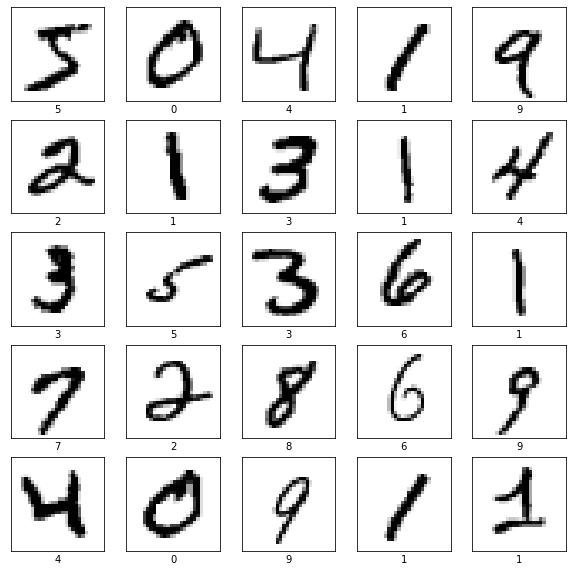

In [182]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()

## Build the model

In [384]:
# Sequential pipeline
# Keras is Tensorflow library
model = keras.Sequential([
    #Layer 1 of neural network
    keras.layers.Flatten(input_shape=(28, 28)),
    # Layer 2
    keras.layers.Dense(128, activation='linear'),
    # Layer 3
    keras.layers.Dense(10, activation='softmax')
])

In [385]:
# Building graph
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Train the model

In [407]:
model.fit(x_train, y_train, epochs=7)

Train on 60000 samples
Epoch 1/7
60000/60000 [==============================] - 4s 62us/sample - loss: 0.2499 - accuracy: 0.9300
Epoch 2/7
60000/60000 [==============================] - 3s 56us/sample - loss: 0.2487 - accuracy: 0.9300
Epoch 3/7
60000/60000 [==============================] - 3s 57us/sample - loss: 0.2495 - accuracy: 0.9297
Epoch 4/7
60000/60000 [==============================] - 3s 58us/sample - loss: 0.2489 - accuracy: 0.9298
Epoch 5/7
60000/60000 [==============================] - 3s 56us/sample - loss: 0.2483 - accuracy: 0.9312
Epoch 6/7
60000/60000 [==============================] - 3s 57us/sample - loss: 0.2478 - accuracy: 0.9303
Epoch 7/7
60000/60000 [==============================] - 3s 57us/sample - loss: 0.2466 - accuracy: 0.9311


## Evaluate accuracy

In [408]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

print('\nTest accuracy:', test_acc)

10000/1 - 0s - loss: 0.2285 - accuracy: 0.9220

Test accuracy: 0.922


## Make predictions

In [409]:
predictions = model.predict(x_test)
predictions[0]

array([1.7659070e-07, 3.8141038e-15, 1.6357799e-07, 8.8303996e-04,
       2.1045244e-08, 1.4108354e-05, 2.2453491e-12, 9.9898833e-01,
       4.2433617e-06, 1.0999880e-04], dtype=float32)

In [410]:
np.argmax(predictions[0])

7

In [411]:
y_test[0]

7

In [412]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format([predicted_label],
                                100*np.max(predictions_array),
                                [true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

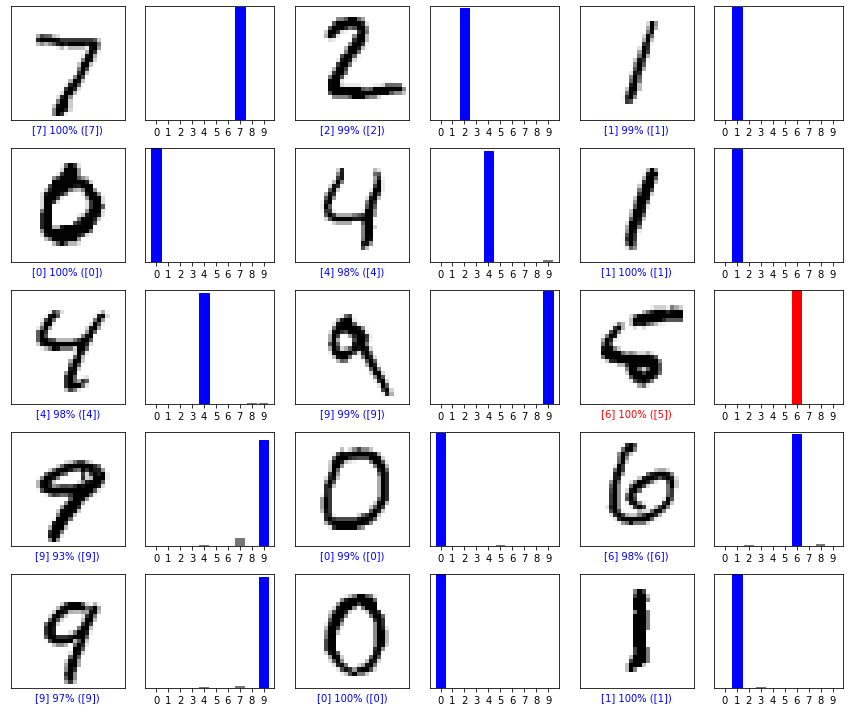

In [413]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], y_test, x_test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], y_test)
plt.tight_layout()
plt.show()

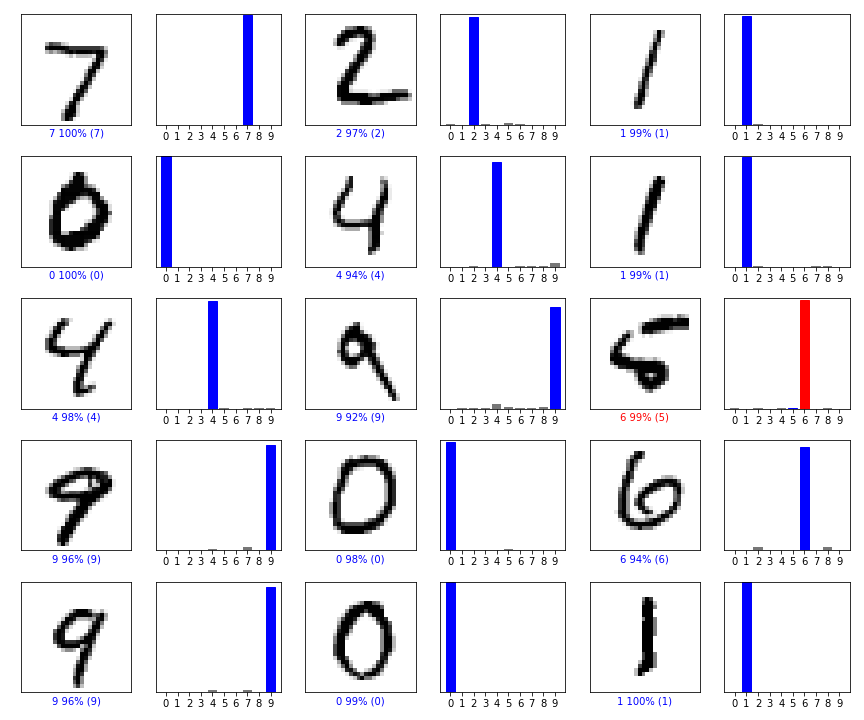

In [339]:
from IPython.display import Image
Image(filename=r'mnist.png')